# 🐰 Bunny's Carrot Quest: A Gradient Descent Adventure!

## An Interactive Introduction to Optimization for Deep Learning

---

**Welcome, future ML engineer!** 🎓

In this notebook, you'll learn one of the most fundamental concepts in deep learning: **gradient descent**. But instead of math, we'll learn by helping a hungry pixel bunny find carrots!

### What You'll Learn:
1. What is a **loss landscape** and why it matters
2. How **gradient descent** works (spoiler: it's just walking downhill!)
3. Why **learning rate** is crucial (hop too big = miss the carrot!)
4. How different **optimizers** (SGD, Momentum, Adam) behave
5. How this connects to **PyTorch** and real neural networks

### The Metaphor 🥕

| Deep Learning Concept | Bunny's World |
|----------------------|---------------|
| Loss function | Height of the terrain |
| Model weights | Bunny's position (x, y) |
| Gradient | Direction of steepest slope |
| Learning rate | How far the bunny hops |
| Training | Bunny hopping toward carrots |
| Global minimum | The BIGGEST carrot! |

---

## 📦 Setup: Import Libraries

First, let's import everything we need. Run this cell!

In [24]:
# Core libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle, Circle, Polygon, FancyBboxPatch
from matplotlib.collections import PatchCollection
import matplotlib.animation as animation
from IPython.display import HTML, display, clear_output
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import time
import warnings
warnings.filterwarnings('ignore')

# Fallback to inline backend to avoid environment errors
# Note: Clicking and real-time animation will be disabled.
%matplotlib inline

print("✅ All libraries loaded! (Using static plots due to environment limitations) 🥕")

✅ All libraries loaded! (Using static plots due to environment limitations) 🥕


---

## 🎨 Part 1: Creating Our Pixel Art World

Before we can teach gradient descent, we need to create our pixel bunny and carrots! The bunny will hop like the Prince from the classic **Prince of Persia** game.

### The Pixel Art Engine

In [25]:
class PixelArtist:
    """
    Creates pixel art sprites for our gradient descent visualization.
    Inspired by classic games like Prince of Persia!
    """

    # Color palette (retro game style!)
    COLORS = {
        'white': '#FFFFFF',
        'cream': '#FFF8DC',
        'pink': '#FFB6C1',
        'black': '#1a1a1a',
        'orange': '#FF8C00',
        'dark_orange': '#FF6600',
        'green': '#228B22',
        'light_green': '#32CD32',
        'brown': '#8B4513',
        'eye': '#2d1b00',
    }

    @staticmethod
    def create_bunny_sprite(frame='idle', direction='right', scale=1.0):
        """
        Create a pixel bunny sprite.

        Frames: 'idle', 'crouch', 'jump', 'peak'
        Direction: 'left' or 'right'

        Returns: List of (Rectangle, color) for matplotlib patches
        """
        patches = []
        pixel_size = 0.08 * scale

        # Animation offsets for Prince of Persia style jump
        offsets = {
            'idle': {'body_y': 0, 'ear_y': 0, 'leg_stretch': 0},
            'crouch': {'body_y': -0.1, 'ear_y': -0.15, 'leg_stretch': -0.05},
            'jump': {'body_y': 0.3, 'ear_y': 0.35, 'leg_stretch': 0.1},
            'peak': {'body_y': 0.4, 'ear_y': 0.5, 'leg_stretch': 0.15},
        }
        off = offsets.get(frame, offsets['idle'])

        def add_pixel(x, y, color):
            """Add a single pixel as a rectangle."""
            rect = Rectangle((x * pixel_size, y * pixel_size + off['body_y']),
                            pixel_size * 0.95, pixel_size * 0.95)
            patches.append((rect, color))

        # === BUNNY BODY (12x16 pixel grid) ===

        # Ears (tall and floppy!) - offset more during jump
        ear_extra = off['ear_y'] - off['body_y']
        for y in range(12, 16):
            add_pixel(2, y + ear_extra/pixel_size, 'white')
            add_pixel(3, y + ear_extra/pixel_size, 'white')
            add_pixel(7, y + ear_extra/pixel_size, 'white')
            add_pixel(8, y + ear_extra/pixel_size, 'white')
        # Inner ear pink
        for y in range(13, 15):
            add_pixel(2.5, y + ear_extra/pixel_size, 'pink')
            add_pixel(7.5, y + ear_extra/pixel_size, 'pink')

        # Head (round)
        for y in range(8, 12):
            for x in range(1, 10):
                dist = np.sqrt((x - 5)**2 + (y - 10)**2)
                if dist < 4.5:
                    add_pixel(x, y, 'white')

        # Eyes
        add_pixel(3, 10, 'black')
        add_pixel(7, 10, 'black')
        # Eye shine
        add_pixel(3.3, 10.3, 'white')
        add_pixel(7.3, 10.3, 'white')

        # Nose
        add_pixel(5, 9, 'pink')

        # Cheeks
        add_pixel(2, 9, 'pink')
        add_pixel(8, 9, 'pink')

        # Body (chonky oval)
        for y in range(3, 8):
            for x in range(1, 10):
                dist_x = (x - 5) / 4.5
                dist_y = (y - 5) / 2.5
                if dist_x**2 + dist_y**2 < 1:
                    add_pixel(x, y, 'cream')

        # Tail (fluffy poof on the back)
        tail_x = 9 if direction == 'right' else 0
        for y in range(5, 7):
            add_pixel(tail_x, y, 'white')
            add_pixel(tail_x + 0.5, y + 0.3, 'white')

        # Feet (stretch during jump!)
        leg_y = 1 + off['leg_stretch'] / pixel_size
        # Back feet
        for x in range(2, 5):
            add_pixel(x, leg_y, 'white')
            add_pixel(x, leg_y - 1, 'white')
        # Front feet
        for x in range(6, 9):
            add_pixel(x, leg_y - off['leg_stretch']/(pixel_size*2), 'white')
            add_pixel(x, leg_y - 1 - off['leg_stretch']/(pixel_size*2), 'white')

        # Flip for direction
        if direction == 'left':
            flipped = []
            for rect, color in patches:
                x, y = rect.get_xy()
                new_x = (10 * pixel_size) - x - rect.get_width()
                new_rect = Rectangle((new_x, y), rect.get_width(), rect.get_height())
                flipped.append((new_rect, color))
            patches = flipped

        return patches, pixel_size * 11  # Return patches and sprite width

    @staticmethod
    def create_carrot_sprite(size_scale=1.0):
        """
        Create a pixel carrot sprite.
        size_scale: Bigger carrots for lower loss values!
        """
        patches = []
        pixel_size = 0.06 * size_scale

        def add_pixel(x, y, color):
            rect = Rectangle((x * pixel_size, y * pixel_size),
                            pixel_size * 0.95, pixel_size * 0.95)
            patches.append((rect, color))

        # Carrot top (green leaves)
        for i in range(-1, 2):
            for y in range(8, 11):
                add_pixel(3 + i, y, 'green' if i == 0 else 'light_green')

        # Carrot body (triangle-ish, pointing down)
        for y in range(0, 8):
            width = int((8 - y) / 2) + 1
            for x in range(3 - width + 1, 3 + width):
                color = 'orange' if (x + y) % 2 == 0 else 'dark_orange'
                add_pixel(x, y, color)

        return patches, pixel_size * 7

# Test our pixel art!
print("🎨 Pixel Artist loaded! Let's see our bunny...")

🎨 Pixel Artist loaded! Let's see our bunny...


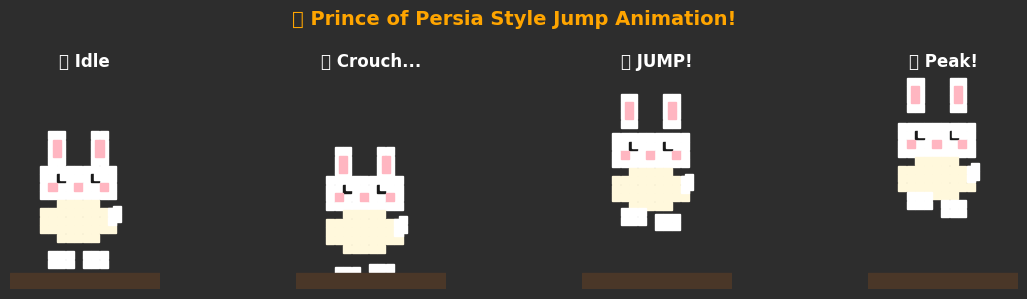


👆 This is how our bunny will hop through the loss landscape!


In [26]:
# Preview the bunny animation frames
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
fig.patch.set_facecolor('#2d2d2d')

frames = ['idle', 'crouch', 'jump', 'peak']
titles = ['🐰 Idle', '🐰 Crouch...', '🐰 JUMP!', '🐰 Peak!']

for ax, frame, title in zip(axes, frames, titles):
    ax.set_facecolor('#1a1a2e')
    ax.set_xlim(-0.2, 1.2)
    ax.set_ylim(-0.2, 1.8)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title, color='white', fontsize=12, fontweight='bold')

    # Draw bunny
    patches, width = PixelArtist.create_bunny_sprite(frame=frame, direction='right', scale=1.0)
    for rect, color_name in patches:
        color = PixelArtist.COLORS.get(color_name, color_name)
        rect.set_facecolor(color)
        rect.set_edgecolor(color)
        ax.add_patch(rect)

    # Draw ground
    ground = Rectangle((-0.2, -0.2), 1.4, 0.15, color='#4a3728')
    ax.add_patch(ground)

plt.suptitle('🎮 Prince of Persia Style Jump Animation!', color='#ffa500', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
print("\n👆 This is how our bunny will hop through the loss landscape!")

---

## 🏔️ Part 2: Understanding Loss Landscapes

### What IS a Loss Landscape?

In deep learning, we train neural networks by **minimizing a loss function**. This function measures "how wrong" our model is:

- **High loss** = Bad predictions = Bunny is far from carrots 😢
- **Low loss** = Good predictions = Bunny found the carrots! 🥕

If we plot the loss as a function of our model's weights, we get a **landscape**. The bunny (our optimizer) needs to find the lowest point!

### Let's Create Some Landscapes

In [27]:
class LossLandscape:
    """
    Different loss landscape functions.
    Each teaches something different about optimization!
    """

    @staticmethod
    def simple_bowl(x, y):
        """
        Simple quadratic bowl - easiest to optimize!
        Real-world analog: Linear regression loss near optimum.
        """
        return 0.5 * (x**2 + y**2)

    @staticmethod
    def narrow_valley(x, y):
        """
        Elongated valley - shows why momentum helps!
        Real-world analog: Neural nets with different scale features.
        """
        return 0.5 * (0.1 * x**2 + 10 * y**2)

    @staticmethod
    def bumpy_terrain(x, y):
        """
        Multiple local minima - the bunny might get stuck!
        Real-world analog: Non-convex deep learning landscapes.
        """
        return 1 + (x**2 - np.cos(2 * np.pi * x)) + (y**2 - np.cos(2 * np.pi * y))

    @staticmethod
    def saddle_point(x, y):
        """
        Saddle point - tricky! Minimum in one direction, maximum in another.
        Real-world analog: Very common in high-dimensional neural nets.
        """
        return x**2 - y**2 + 0.5 * (x**2 + y**2) * 0.1

    @staticmethod
    def banana_valley(x, y):
        """
        Rosenbrock's banana function - classic optimization test!
        The minimum is inside a curved, narrow valley.
        """
        a, b = 1, 5
        return (a - x)**2 + b * (y - x**2)**2

# Dictionary of landscapes with descriptions
LANDSCAPES = {
    'Simple Bowl': {
        'func': LossLandscape.simple_bowl,
        'description': 'Easy! All paths lead to the center.',
        'difficulty': '⭐',
        'tip': 'Any optimizer works here!'
    },
    'Narrow Valley': {
        'func': LossLandscape.narrow_valley,
        'description': 'Steep sides, gentle slope along valley.',
        'difficulty': '⭐⭐',
        'tip': 'Watch SGD zigzag! Momentum helps.'
    },
    'Bumpy Terrain': {
        'func': LossLandscape.bumpy_terrain,
        'description': 'Multiple hills and valleys - local minima!',
        'difficulty': '⭐⭐⭐',
        'tip': 'Bunny might get stuck in a small valley!'
    },
    'Saddle Point': {
        'func': LossLandscape.saddle_point,
        'description': 'Like a horse saddle - tricky terrain!',
        'difficulty': '⭐⭐⭐',
        'tip': 'The center looks flat but isn\'t the minimum!'
    },
    'Banana Valley': {
        'func': LossLandscape.banana_valley,
        'description': 'Curved valley with minimum at (1, 1)',
        'difficulty': '⭐⭐⭐⭐',
        'tip': 'Classic test! Can your optimizer navigate the curve?'
    }
}

print("🏔️ Loss landscapes defined! Each teaches a different lesson.")

🏔️ Loss landscapes defined! Each teaches a different lesson.


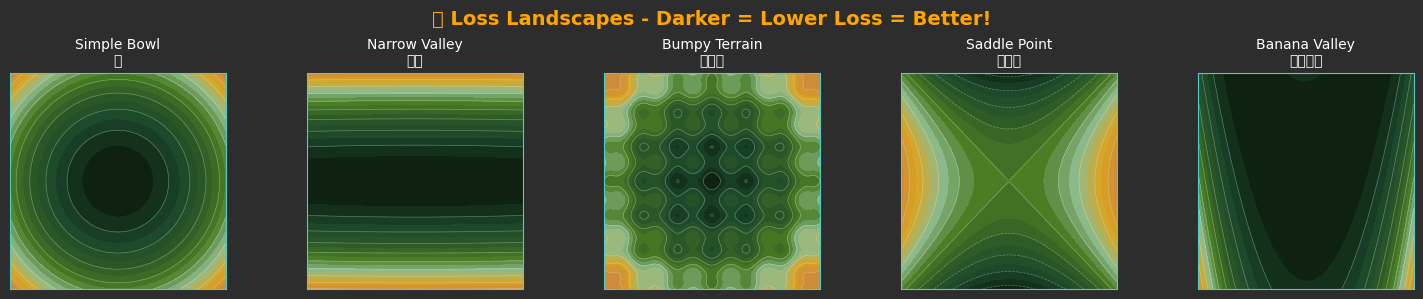

In [28]:
# Visualize all landscapes
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
fig.patch.set_facecolor('#2d2d2d')

# Custom colormap (grass -> dirt -> underground)
colors = ['#0d1b0d', '#1a472a', '#2d5a27', '#4a7c23', '#8fbc8f', '#daa520', '#cd853f']
cmap = LinearSegmentedColormap.from_list('terrain', colors)

x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)

for ax, (name, info) in zip(axes, LANDSCAPES.items()):
    Z = info['func'](X, Y)

    ax.contourf(X, Y, Z, levels=20, cmap=cmap)
    ax.contour(X, Y, Z, levels=10, colors='white', alpha=0.3, linewidths=0.5)
    ax.set_title(f"{name}\n{info['difficulty']}", color='white', fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    for spine in ax.spines.values():
        spine.set_color('#4ecdc4')

plt.suptitle('🗺️ Loss Landscapes - Darker = Lower Loss = Better!',
             color='#ffa500', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---

## 🧮 Part 3: The Math of Gradient Descent

### The Core Idea

Gradient descent is surprisingly simple:

1. **Look around** - Which direction goes downhill? (compute gradient)
2. **Take a step** - Walk downhill! (update weights)
3. **Repeat** - Until you reach the bottom (minimum loss)

### The Math (Don't Panic! 🐰)

$$\theta_{new} = \theta_{old} - \alpha \cdot \nabla L(\theta)$$

Where:
- $\theta$ = model weights (bunny's position)
- $\alpha$ = learning rate (hop size)
- $\nabla L$ = gradient (direction of steepest UP, so we go opposite!)

### Let's Implement It!

In [29]:
def compute_gradient(func, x, y, epsilon=1e-5):
    """
    Compute the gradient using finite differences.

    This is like the bunny feeling the slope under its feet!

    In real PyTorch, autograd does this automatically.
    """
    # Partial derivative with respect to x
    df_dx = (func(x + epsilon, y) - func(x - epsilon, y)) / (2 * epsilon)

    # Partial derivative with respect to y
    df_dy = (func(x, y + epsilon) - func(x, y - epsilon)) / (2 * epsilon)

    return np.array([df_dx, df_dy])


# Test it!
print("Testing gradient at position (1, 1) on Simple Bowl:")
grad = compute_gradient(LossLandscape.simple_bowl, 1.0, 1.0)
print(f"  Gradient: [{grad[0]:.2f}, {grad[1]:.2f}]")
print(f"  This means: slope goes UP in both directions!")
print(f"  So bunny should hop in NEGATIVE direction (toward center)")

Testing gradient at position (1, 1) on Simple Bowl:
  Gradient: [1.00, 1.00]
  This means: slope goes UP in both directions!
  So bunny should hop in NEGATIVE direction (toward center)


---

## 🐰 Part 4: Meet the Optimizers!

Different optimizers are like different **hopping strategies** for our bunny. Some are simple, some are clever!

### The Competitors

In [30]:
class VanillaSGD:
    """
    🐰 Vanilla SGD - The Basic Hopper

    Just hops in the direction of steepest descent.
    Simple but can be slow or zigzag in narrow valleys!

    PyTorch equivalent:
        torch.optim.SGD(model.parameters(), lr=0.1)
    """
    def __init__(self, learning_rate=0.1):
        self.lr = learning_rate
        self.name = "Vanilla SGD"
        self.color = '#ff6b6b'
        self.emoji = '🐰'

    def step(self, position, gradient):
        # Simple! Just go opposite to gradient
        return position - self.lr * gradient

    def reset(self):
        pass  # No state to reset


class MomentumSGD:
    """
    🐰💨 Momentum - The Bouncy Hopper

    Remembers previous hops and builds up speed!
    Like a ball rolling downhill - accelerates in consistent directions.

    PyTorch equivalent:
        torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    """
    def __init__(self, learning_rate=0.1, momentum=0.9):
        self.lr = learning_rate
        self.momentum = momentum
        self.velocity = None
        self.name = "Momentum"
        self.color = '#4ecdc4'
        self.emoji = '🐰💨'

    def step(self, position, gradient):
        if self.velocity is None:
            self.velocity = np.zeros_like(position)

        # Build up velocity from past gradients
        self.velocity = self.momentum * self.velocity - self.lr * gradient
        return position + self.velocity

    def reset(self):
        self.velocity = None


class RMSprop:
    """
    🐰🎯 RMSprop - The Adaptive Hopper

    Adapts hop size based on how bumpy each direction is!
    Smaller hops where it's rough, bigger hops where it's smooth.

    PyTorch equivalent:
        torch.optim.RMSprop(model.parameters(), lr=0.01)
    """
    def __init__(self, learning_rate=0.1, decay=0.99, epsilon=1e-8):
        self.lr = learning_rate
        self.decay = decay
        self.epsilon = epsilon
        self.cache = None
        self.name = "RMSprop"
        self.color = '#45b7d1'
        self.emoji = '🐰🎯'

    def step(self, position, gradient):
        if self.cache is None:
            self.cache = np.zeros_like(position)

        # Track squared gradients (how bumpy is each direction?)
        self.cache = self.decay * self.cache + (1 - self.decay) * gradient**2

        # Adapt step size: divide by sqrt of bumpiness
        return position - self.lr * gradient / (np.sqrt(self.cache) + self.epsilon)

    def reset(self):
        self.cache = None


class Adam:
    """
    🐰👑 Adam - The Champion Hopper!

    Combines momentum AND adaptive learning rates.
    The most popular optimizer in deep learning!

    PyTorch equivalent:
        torch.optim.Adam(model.parameters(), lr=0.001)
    """
    def __init__(self, learning_rate=0.1, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.lr = learning_rate
        self.beta1 = beta1  # Momentum coefficient
        self.beta2 = beta2  # RMSprop coefficient
        self.epsilon = epsilon
        self.m = None  # First moment (momentum)
        self.v = None  # Second moment (RMSprop)
        self.t = 0     # Time step
        self.name = "Adam"
        self.color = '#f9ca24'
        self.emoji = '🐰👑'

    def step(self, position, gradient):
        if self.m is None:
            self.m = np.zeros_like(position)
            self.v = np.zeros_like(position)

        self.t += 1

        # Update momentum (like MomentumSGD)
        self.m = self.beta1 * self.m + (1 - self.beta1) * gradient

        # Update squared gradient tracking (like RMSprop)
        self.v = self.beta2 * self.v + (1 - self.beta2) * gradient**2

        # Bias correction (important for early steps!)
        m_hat = self.m / (1 - self.beta1**self.t)
        v_hat = self.v / (1 - self.beta2**self.t)

        # Combined update
        return position - self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)

    def reset(self):
        self.m = None
        self.v = None
        self.t = 0


# All our optimizers!
OPTIMIZERS = {
    'SGD': VanillaSGD,
    'Momentum': MomentumSGD,
    'RMSprop': RMSprop,
    'Adam': Adam
}

print("🎮 Optimizers ready!")
print("\n" + "="*50)
for name, opt_class in OPTIMIZERS.items():
    opt = opt_class()
    print(f"{opt.emoji} {opt.name}: {opt_class.__doc__.split(chr(10))[2].strip()}")
print("="*50)

🎮 Optimizers ready!

🐰 Vanilla SGD: 
🐰💨 Momentum: 
🐰🎯 RMSprop: 
🐰👑 Adam: 


---

## 🎮 Part 5: Interactive Bunny Adventure!

Now for the fun part - **click on the landscape** to place your bunny, then watch it hop toward the carrots!

### How It Works:
1. **Click** anywhere on the landscape to set the bunny's starting position
2. **Watch** the bunny hop toward the lowest point (biggest carrot!)
3. **Experiment** with different optimizers and learning rates!

In [42]:
class BunnyAdventure:
    """
    Interactive gradient descent visualization with pixel art!
    Updated for Colab: Uses sliders, Output widgets, and JSHTML animation for smooth rendering.
    """

    def __init__(self, output_widget=None):
        # Target widget for display (prevents clearing controls)
        self.output_widget = output_widget

        # Terrain colors
        self.colors = ['#0d1b0d', '#1a472a', '#2d5a27', '#4a7c23', '#8fbc8f', '#daa520', '#cd853f']
        self.cmap = LinearSegmentedColormap.from_list('terrain', self.colors)

        # State
        self.bunny_pos = None
        self.trajectory = []
        self.is_animating = False
        self.landscape_func = LossLandscape.simple_bowl
        self.landscape_name = 'Simple Bowl'
        self.optimizer = None
        self.learning_rate = 0.1

        # Create figure
        self.fig, self.axes = plt.subplots(1, 2, figsize=(14, 6))
        self.fig.patch.set_facecolor('#1a1a2e')
        plt.close(self.fig)

        # Initial draw setup
        self.draw_landscape()

    def _display_content(self, content):
        """Helper to display content in the correct output widget."""
        if self.output_widget:
            with self.output_widget:
                clear_output(wait=True)
                display(content)
        else:
            clear_output(wait=True)
            display(content)

    def draw_landscape(self):
        """Draw the loss landscape with carrots."""
        ax = self.axes[0]
        ax.clear()
        ax.set_facecolor('#1a1a2e')

        # Create meshgrid
        x = np.linspace(-3.5, 3.5, 150)
        y = np.linspace(-3.5, 3.5, 150)
        X, Y = np.meshgrid(x, y)
        Z = self.landscape_func(X, Y)

        # Draw contours
        ax.contourf(X, Y, Z, levels=25, cmap=self.cmap, alpha=0.9)
        ax.contour(X, Y, Z, levels=12, colors='white', alpha=0.2, linewidths=0.5)

        # Add carrots
        self.draw_carrots(ax)

        # Draw trajectory if exists
        if len(self.trajectory) > 1:
            traj = np.array(self.trajectory)
            color = self.optimizer.color if self.optimizer else '#ff6b6b'
            ax.plot(traj[:, 0], traj[:, 1], color=color, linewidth=2,
                   alpha=0.7, linestyle='--', zorder=5)

            # Draw hop markers
            for i in range(0, len(traj), 2):
                ax.scatter(traj[i, 0], traj[i, 1], color=color, s=30, alpha=0.5, zorder=6)

        # Draw bunny at current position
        if self.bunny_pos is not None:
            self.draw_bunny(ax, self.bunny_pos[0], self.bunny_pos[1])

        ax.set_xlim(-3.5, 3.5)
        ax.set_ylim(-3.5, 3.5)
        ax.set_xlabel('Weight 1', color='white', fontsize=11)
        ax.set_ylabel('Weight 2', color='white', fontsize=11)
        ax.set_title(f'🗺️ {self.landscape_name}',
                    color='white', fontsize=12, fontweight='bold')
        ax.tick_params(colors='white')
        for spine in ax.spines.values():
            spine.set_color('#4ecdc4')

        # Draw loss plot
        self.draw_loss_plot()

        # Display the updated figure
        self._display_content(self.fig)

    def draw_carrots(self, ax):
        carrot_positions = [
            (0, 0), (-2, 0), (2, 0), (0, -2), (0, 2),
            (-2, -2), (2, 2), (-2, 2), (2, -2),
        ]
        for cx, cy in carrot_positions:
            loss = self.landscape_func(cx, cy)
            max_loss = self.landscape_func(3, 3)
            scale = 1.5 - (loss / (max_loss + 0.1))
            scale = np.clip(scale, 0.3, 1.5)
            self.draw_pixel_carrot(ax, cx, cy, scale)

    def draw_pixel_carrot(self, ax, x, y, scale=1.0):
        patches_list, width = PixelArtist.create_carrot_sprite(scale)
        for rect, color_name in patches_list:
            rx, ry = rect.get_xy()
            w, h = rect.get_width(), rect.get_height()
            new_rect = Rectangle((x + rx - width/2, y + ry - width/2), w, h)
            color = PixelArtist.COLORS.get(color_name, color_name)
            new_rect.set_facecolor(color)
            new_rect.set_edgecolor(color)
            ax.add_patch(new_rect)

    def draw_bunny(self, ax, x, y, frame='idle'):
        direction = 'right'
        if len(self.trajectory) >= 2:
            last_pos = self.trajectory[-2] if len(self.trajectory) > 1 else self.trajectory[-1]
            if x < last_pos[0]:
                direction = 'left'
        patches_list, width = PixelArtist.create_bunny_sprite(frame=frame, direction=direction, scale=0.8)
        for rect, color_name in patches_list:
            rx, ry = rect.get_xy()
            w, h = rect.get_width(), rect.get_height()
            new_rect = Rectangle((x + rx - width/2, y + ry - width/3), w, h, zorder=100)
            color = PixelArtist.COLORS.get(color_name, color_name)
            new_rect.set_facecolor(color)
            new_rect.set_edgecolor(color)
            ax.add_patch(new_rect)

    def draw_loss_plot(self, ax=None):
        if ax is None:
            ax = self.axes[1]
        ax.clear()
        ax.set_facecolor('#1a1a2e')

        if len(self.trajectory) > 0:
            losses = [self.landscape_func(p[0], p[1]) for p in self.trajectory]
            color = self.optimizer.color if self.optimizer else '#ff6b6b'
            ax.plot(losses, color=color, linewidth=2.5, marker='o', markersize=4)

            ax.annotate(f'Current: {losses[-1]:.3f}',
                       xy=(len(losses)-1, losses[-1]),
                       xytext=(10, 10), textcoords='offset points',
                       color='white', fontsize=10,
                       bbox=dict(boxstyle='round', facecolor=color, alpha=0.5))

        ax.set_xlabel('Hop Number 🐾', color='white', fontsize=11)
        ax.set_ylabel('Loss (lower = more carrots!) 🥕', color='white', fontsize=11)
        opt_name = self.optimizer.name if self.optimizer else 'SGD'
        ax.set_title(f'📉 {opt_name} Progress\nLR = {self.learning_rate}',
                    color='white', fontsize=12, fontweight='bold')
        ax.tick_params(colors='white')
        ax.grid(True, alpha=0.2, color='white')
        for spine in ax.spines.values():
            spine.set_color('#4ecdc4')

    def start_animation_from(self, x, y):
        if self.is_animating: return

        self.bunny_pos = np.array([float(x), float(y)])
        self.trajectory = [self.bunny_pos.copy()]

        if self.optimizer:
            self.optimizer.reset()

        self.animate_hops(30)

    def animate_hops(self, num_hops):
        """Pre-render animation to avoid flickering."""
        self.is_animating = True

        # Show loading message
        if self.output_widget:
            with self.output_widget:
                print("🐰 Computing trajectory and rendering animation... (this takes a moment)")
        else:
            print("🐰 Computing trajectory and rendering animation...")

        # 1. Compute Trajectory
        current_pos = self.bunny_pos.copy()
        for _ in range(num_hops):
            grad = compute_gradient(self.landscape_func, current_pos[0], current_pos[1])

            if self.optimizer:
                new_pos = self.optimizer.step(current_pos, grad)
            else:
                new_pos = current_pos - self.learning_rate * grad

            new_pos = np.clip(new_pos, -3.5, 3.5)

            if np.linalg.norm(new_pos - current_pos) < 0.01:
                break

            current_pos = new_pos
            self.trajectory.append(current_pos.copy())

        self.bunny_pos = current_pos

        # 2. Setup Animation
        # We need a NEW figure for the animation to avoid messing up self.fig reference loop
        fig_anim, axes_anim = plt.subplots(1, 2, figsize=(14, 6))
        fig_anim.patch.set_facecolor('#1a1a2e')
        plt.close(fig_anim)

        frames_per_hop = 5
        bunny_frames = ['crouch', 'jump', 'peak', 'jump', 'idle']
        total_hops = len(self.trajectory) - 1
        total_frames = total_hops * frames_per_hop

        def update(frame_idx):
            hop_idx = frame_idx // frames_per_hop
            sub_idx = frame_idx % frames_per_hop

            if hop_idx >= total_hops:
                pos = self.trajectory[-1]
                current_frame = 'idle'
            else:
                start = self.trajectory[hop_idx]
                end = self.trajectory[hop_idx + 1]
                t = sub_idx / (frames_per_hop - 1)
                pos = start + t * (end - start)
                current_frame = bunny_frames[sub_idx]

            # Draw on the animation figure axes
            self.draw_landscape_static(axes_anim[0], pos, current_frame, hop_idx)
            self.draw_loss_plot_static(axes_anim[1], hop_idx)

            return axes_anim

        # 3. Helpers for animation frames (to separate from main draw logic)
        self._anim_trajectory_cache = self.trajectory.copy()

        anim = animation.FuncAnimation(fig_anim, update, frames=total_frames + 5, interval=50)
        html_content = HTML(anim.to_jshtml())

        # 4. Display Result
        self._display_content(html_content)
        self.is_animating = False

    def draw_landscape_static(self, ax, pos, frame, hop_idx):
        ax.clear()
        ax.set_facecolor('#1a1a2e')

        x = np.linspace(-3.5, 3.5, 100)
        y = np.linspace(-3.5, 3.5, 100)
        X, Y = np.meshgrid(x, y)
        Z = self.landscape_func(X, Y)
        ax.contourf(X, Y, Z, levels=25, cmap=self.cmap, alpha=0.9)
        ax.contour(X, Y, Z, levels=12, colors='white', alpha=0.2, linewidths=0.5)

        self.draw_carrots(ax)

        # Draw full trajectory up to now
        current_traj = np.array(self._anim_trajectory_cache[:hop_idx+2])
        if len(current_traj) > 1:
            color = self.optimizer.color if self.optimizer else '#ff6b6b'
            ax.plot(current_traj[:, 0], current_traj[:, 1], color=color,
                    linewidth=2, alpha=0.7, linestyle='--', zorder=5)

        self.draw_bunny(ax, pos[0], pos[1], frame=frame)

        ax.set_xlim(-3.5, 3.5)
        ax.set_ylim(-3.5, 3.5)
        ax.set_xlabel('Weight 1', color='white', fontsize=11)
        ax.set_ylabel('Weight 2', color='white', fontsize=11)
        ax.set_title(f'🗺️ {self.landscape_name}', color='white', fontsize=12, fontweight='bold')
        ax.tick_params(colors='white')
        for spine in ax.spines.values():
            spine.set_color('#4ecdc4')

    def draw_loss_plot_static(self, ax, hop_idx):
        ax.clear()
        ax.set_facecolor('#1a1a2e')

        # Spoof trajectory for this frame
        current_len = hop_idx + 2
        full_losses = [self.landscape_func(p[0], p[1]) for p in self._anim_trajectory_cache]
        current_losses = full_losses[:current_len]

        color = self.optimizer.color if self.optimizer else '#ff6b6b'
        ax.plot(current_losses, color=color, linewidth=2.5, marker='o', markersize=4)

        ax.set_xlabel('Hop Number 🐾', color='white', fontsize=11)
        ax.set_ylabel('Loss 🥕', color='white', fontsize=11)
        ax.set_title(f'📉 Loss: {current_losses[-1]:.3f}', color='white', fontsize=12, fontweight='bold')
        ax.tick_params(colors='white')
        ax.grid(True, alpha=0.2, color='white')
        for spine in ax.spines.values():
            spine.set_color('#4ecdc4')

    def set_landscape(self, name):
        self.landscape_name = name
        self.landscape_func = LANDSCAPES[name]['func']
        self.trajectory = []
        self.bunny_pos = None
        if self.optimizer:
            self.optimizer.reset()
        self.draw_landscape()

    def set_optimizer(self, name, lr):
        self.learning_rate = lr
        if name in OPTIMIZERS:
            self.optimizer = OPTIMIZERS[name](learning_rate=lr)
        else:
            self.optimizer = VanillaSGD(learning_rate=lr)
        self.trajectory = []
        if self.bunny_pos is not None:
            self.trajectory = [self.bunny_pos.copy()]

print("🎮 BunnyAdventure updated: FLICKER-FREE MODE! ✨")

🎮 BunnyAdventure updated: FLICKER-FREE MODE! ✨


### 🎮 Let's Play!

Run the cell below to start the interactive adventure. Use the controls to:
1. Choose a **landscape** (try Narrow Valley to see momentum shine!)
2. Choose an **optimizer** (compare SGD vs Adam!)
3. Adjust the **learning rate** (too high = bunny goes crazy!)
4. **Click** on the landscape to place your bunny!

In [43]:
# Create Output widget for the plot to avoid clearing controls
plot_output = widgets.Output()

# Create the adventure with the output target
adventure = BunnyAdventure(output_widget=plot_output)

# --- Control Widgets ---
style = {'description_width': 'initial'}

landscape_dropdown = widgets.Dropdown(
    options=list(LANDSCAPES.keys()),
    value='Simple Bowl',
    description='🗺️ Landscape:',
    style=style
)

optimizer_dropdown = widgets.Dropdown(
    options=list(OPTIMIZERS.keys()),
    value='SGD',
    description='🐰 Optimizer:',
    style=style
)

lr_slider = widgets.FloatSlider(
    value=0.1, min=0.001, max=1.0, step=0.001,
    description='🦘 Learning Rate:',
    style=style, readout_format='.3f'
)

start_x_slider = widgets.FloatSlider(
    value=2.5, min=-3.0, max=3.0, step=0.1,
    description='📍 Start X:',
    style=style
)

start_y_slider = widgets.FloatSlider(
    value=2.5, min=-3.0, max=3.0, step=0.1,
    description='📍 Start Y:',
    style=style
)

run_button = widgets.Button(
    description='🐰 HOP! 🥕',
    button_style='success',
    layout=widgets.Layout(width='100%', height='40px'),
    icon='play'
)

# --- Event Handlers ---
def on_landscape_change(change):
    adventure.set_landscape(change['new'])

def on_optimizer_change(change):
    adventure.set_optimizer(change['new'], lr_slider.value)

def on_lr_change(change):
    adventure.set_optimizer(optimizer_dropdown.value, change['new'])

def on_run_click(b):
    run_button.disabled = True
    run_button.description = "🐰 Rendering Animation..."

    # The magic happens here
    adventure.start_animation_from(start_x_slider.value, start_y_slider.value)

    run_button.disabled = False
    run_button.description = '🐰 HOP! 🥕'

# Connect handlers
landscape_dropdown.observe(on_landscape_change, names='value')
optimizer_dropdown.observe(on_optimizer_change, names='value')
lr_slider.observe(on_lr_change, names='value')
run_button.on_click(on_run_click)

# --- Layout ---
controls = widgets.VBox([
    widgets.HTML("<h3 style='color: #ffa500;'>🎮 Control Panel</h3>"),
    landscape_dropdown,
    optimizer_dropdown,
    lr_slider,
    widgets.HTML("<hr>"),
    widgets.HTML("<b style='color: #4ecdc4;'>👇 Set Start Position & Run:</b>"),
    start_x_slider,
    start_y_slider,
    run_button
])

# Display layout
display(controls)
display(plot_output)

# Initial Draw
adventure.set_optimizer('SGD', 0.1)

print("✅ Controls ready! Flicker-free animation enabled.")

Output()

✅ Controls ready! Flicker-free animation enabled.


### 👗 Real PyTorch Data: Fashion MNIST

Instead of boring math numbers, let's train our bunny on **Fashion MNIST**! We'll download images of clothes and create a `DataLoader` that feeds them to our model in small batches.

In [44]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# 1. Define transforms (convert images to PyTorch tensors and normalize them)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

print("🐰 Downloading Bunny's Wardrobe (FashionMNIST)... ")

# 2. Download and Load Data
# train=True means we want the training data
# download=True means it downloads from the internet if you don't have it
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)

# 3. Create the DataLoader
# batch_size=4 means we give the model 4 images at a time
# shuffle=True mixes them up so the model doesn't memorize the order
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=0)

# 4. Define Classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

print("✅ Data loaded! We have", len(trainset), "training images.")

🐰 Downloading Bunny's Wardrobe (FashionMNIST)... 


100%|██████████| 26.4M/26.4M [00:01<00:00, 16.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 271kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.04MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.7MB/s]

✅ Data loaded! We have 60000 training images.



👀 Here is a random batch of 4 items:


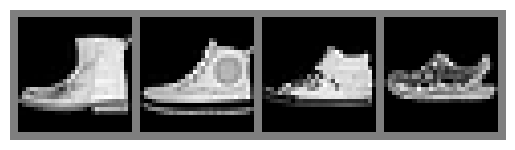

Labels: Ankle boot   Ankle boot   Sneaker      Sandal      

Ready to feed this into the training loop! 🥕


In [45]:
# Let's look at some of the data!
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get a random batch of training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
print(f"\n👀 Here is a random batch of {trainloader.batch_size} items:")
imshow(torchvision.utils.make_grid(images))

# Print labels
print('Labels:', ' '.join(f'{classes[labels[j]]:12s}' for j in range(4)))
print("\nReady to feed this into the training loop! 🥕")

---

## 🔬 Part 6: Experiments to Try!

### Experiment 1: The Zigzag Problem
1. Set landscape to **"Narrow Valley"**
2. Use **SGD** with LR = 0.1
3. Click somewhere away from center
4. Watch SGD zigzag!
5. Now try **Momentum** - see the difference?

### Experiment 2: Learning Rate Chaos
1. Set landscape to **"Simple Bowl"**
2. Use **SGD** with LR = 0.9
3. Click near the edge
4. Watch the bunny overshoot and bounce!
5. Try LR = 0.01 - much smoother but slower

### Experiment 3: Adam Wins
1. Set landscape to **"Banana Valley"**
2. Compare all optimizers with LR = 0.1
3. Adam usually finds the minimum fastest!

### Experiment 4: Local Minima Trap
1. Set landscape to **"Bumpy Terrain"**
2. Click at different starting points
3. Notice how the bunny can get stuck in local minima!

---

## 🔗 Part 7: Connecting to PyTorch

Everything we learned with bunnies applies directly to PyTorch! Here's the translation:

### The PyTorch Training Loop

In [33]:
# This is how the bunny's journey translates to real PyTorch code!

pytorch_code = '''
import torch
import torch.nn as nn
import torch.optim as optim

# 1. Create a model (the bunny!)
model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

# 2. Choose your optimizer (hopping strategy!)
# Try different ones - just like in our game!

optimizer = optim.SGD(model.parameters(), lr=0.1)              # 🐰 Vanilla SGD
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)  # 🐰💨 Momentum
# optimizer = optim.RMSprop(model.parameters(), lr=0.01)           # 🐰🎯 RMSprop
# optimizer = optim.Adam(model.parameters(), lr=0.001)             # 🐰👑 Adam

# 3. Define loss function (the landscape!)
criterion = nn.CrossEntropyLoss()

# 4. Training loop (bunny hopping!)
for epoch in range(num_epochs):
    for inputs, targets in dataloader:

        # Forward pass (bunny looks around)
        outputs = model(inputs)
        loss = criterion(outputs, targets)  # How far from the carrot?

        # Backward pass (compute gradient - which way is downhill?)
        optimizer.zero_grad()  # Clear old gradients
        loss.backward()        # Compute new gradients

        # Update weights (bunny hops!)
        optimizer.step()       # This is where the magic happens!

    print(f"Epoch {epoch}: Loss = {loss.item():.4f}")
'''

print("🔥 PyTorch Training Loop:")
print("="*50)
print(pytorch_code)

🔥 PyTorch Training Loop:

import torch
import torch.nn as nn
import torch.optim as optim

# 1. Create a model (the bunny!)
model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

# 2. Choose your optimizer (hopping strategy!)
# Try different ones - just like in our game!

optimizer = optim.SGD(model.parameters(), lr=0.1)              # 🐰 Vanilla SGD
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)  # 🐰💨 Momentum  
# optimizer = optim.RMSprop(model.parameters(), lr=0.01)           # 🐰🎯 RMSprop
# optimizer = optim.Adam(model.parameters(), lr=0.001)             # 🐰👑 Adam

# 3. Define loss function (the landscape!)
criterion = nn.CrossEntropyLoss()

# 4. Training loop (bunny hopping!)
for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        
        # Forward pass (bunny looks around)
        outputs = model(inputs)
        loss = criterion(outputs, targets)  # How far from the carrot?
        
        # Backward pass 

In [47]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# 1. Define the Model (BunnyNet!)
class BunnyNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Input: 28x28 pixels = 784 inputs
        self.fc1 = nn.Linear(784, 128)  # Hidden layer
        self.fc2 = nn.Linear(128, 10)   # Output: 10 clothing classes

    def forward(self, x):
        x = x.view(-1, 784) # Flatten the image (28x28 -> 784)
        x = F.relu(self.fc1(x)) # Activation function
        x = self.fc2(x)
        return x

model = BunnyNet()

# 2. Choose Optimizer (The Bunny's Strategy)
# FIX: Lowering learning rate from 0.01 to 0.001 to prevent overshooting!
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 3. Define Loss Function (The Landscape)
criterion = nn.CrossEntropyLoss()

print("🐰 Training started! Watch the loss (distance to carrot) decrease...\n")

# 4. Training Loop
running_loss = 0.0
for i, data in enumerate(trainloader, 0):
    inputs, labels = data

    # Zero gradients (reset before looking around)
    optimizer.zero_grad()

    # Forward + Backward + Optimize (Look, calculate slope, hop!)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # Print statistics
    running_loss += loss.item()
    if i % 2000 == 1999:    # Print every 2000 mini-batches
        print(f'[Step {i + 1}] Loss: {running_loss / 2000:.3f} 🥕')
        running_loss = 0.0

print("\n🎉 Finished Training! The bunny has learned to recognize clothes!")

🐰 Training started! Watch the loss (distance to carrot) decrease...

[Step 2000] Loss: 0.748 🥕
[Step 4000] Loss: 0.529 🥕
[Step 6000] Loss: 0.498 🥕
[Step 8000] Loss: 0.457 🥕
[Step 10000] Loss: 0.445 🥕
[Step 12000] Loss: 0.424 🥕
[Step 14000] Loss: 0.417 🥕

🎉 Finished Training! The bunny has learned to recognize clothes!


True Label:  Ankle boot   Ankle boot   Sandal       Shirt       
Predicted:   Ankle boot   Sneaker      Sandal       Shirt       


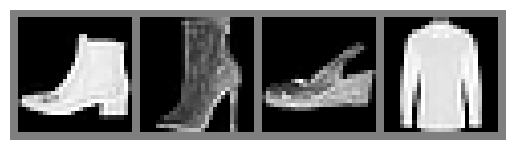

In [48]:
# 5. Visualize Predictions
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Ask the bunny for predictions
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Print results
print('True Label: ', ' '.join(f'{classes[labels[j]]:12s}' for j in range(4)))
print('Predicted:  ', ' '.join(f'{classes[predicted[j]]:12s}' for j in range(4)))

# Show images
imshow(torchvision.utils.make_grid(images))

### Key Mappings

| Bunny's World | PyTorch Code |
|---------------|-------------|
| Bunny's position | `model.parameters()` |
| Looking for slope | `loss.backward()` |
| Taking a hop | `optimizer.step()` |
| Hop size (learning rate) | `lr=0.1` in optimizer |
| Distance to carrot (loss) | `loss.item()` |

---

## 🏆 Part 8: Optimizer Comparison Race!

Let's race all optimizers at once to see who finds the carrot first!

In [49]:
def optimizer_race(landscape_name='Narrow Valley', learning_rate=0.1, start_pos=(3.0, 3.0), num_steps=50):
    """
    Race all optimizers on the same landscape!
    """
    landscape_func = LANDSCAPES[landscape_name]['func']

    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.patch.set_facecolor('#1a1a2e')

    # Create terrain colormap
    colors = ['#0d1b0d', '#1a472a', '#2d5a27', '#4a7c23', '#8fbc8f', '#daa520', '#cd853f']
    cmap = LinearSegmentedColormap.from_list('terrain', colors)

    # Setup landscape
    x = np.linspace(-4, 4, 100)
    y = np.linspace(-4, 4, 100)
    X, Y = np.meshgrid(x, y)
    Z = landscape_func(X, Y)

    ax1 = axes[0]
    ax1.set_facecolor('#1a1a2e')
    ax1.contourf(X, Y, Z, levels=25, cmap=cmap, alpha=0.9)
    ax1.contour(X, Y, Z, levels=12, colors='white', alpha=0.2, linewidths=0.5)

    # Run each optimizer
    results = {}

    for name, opt_class in OPTIMIZERS.items():
        optimizer = opt_class(learning_rate=learning_rate)
        pos = np.array(start_pos, dtype=float)
        trajectory = [pos.copy()]
        losses = [landscape_func(pos[0], pos[1])]

        for _ in range(num_steps):
            grad = compute_gradient(landscape_func, pos[0], pos[1])
            pos = optimizer.step(pos, grad)
            pos = np.clip(pos, -4, 4)
            trajectory.append(pos.copy())
            losses.append(landscape_func(pos[0], pos[1]))

        results[name] = {
            'optimizer': optimizer,
            'trajectory': np.array(trajectory),
            'losses': np.array(losses)
        }

        # Plot trajectory
        traj = results[name]['trajectory']
        ax1.plot(traj[:, 0], traj[:, 1], color=optimizer.color,
                linewidth=2.5, alpha=0.8, label=f"{optimizer.emoji} {name}")
        ax1.scatter(traj[-1, 0], traj[-1, 1], color=optimizer.color,
                   s=150, marker='o', edgecolors='white', linewidths=2, zorder=10)

    # Mark start and goal
    ax1.scatter(start_pos[0], start_pos[1], color='lime', s=200, marker='*',
               edgecolors='white', linewidths=2, zorder=15, label='Start')
    ax1.scatter(0, 0, color='gold', s=300, marker='*',
               edgecolors='white', linewidths=2, zorder=15, label='Goal 🥕')

    ax1.set_xlim(-4, 4)
    ax1.set_ylim(-4, 4)
    ax1.set_xlabel('Weight 1', color='white', fontsize=11)
    ax1.set_ylabel('Weight 2', color='white', fontsize=11)
    ax1.set_title(f'🏁 Optimizer Race: {landscape_name}\nLR = {learning_rate}',
                 color='white', fontsize=12, fontweight='bold')
    ax1.legend(loc='upper right', fontsize=9, facecolor='#2d2d2d',
              edgecolor='white', labelcolor='white')
    ax1.tick_params(colors='white')
    for spine in ax1.spines.values():
        spine.set_color('#4ecdc4')

    # Loss plot
    ax2 = axes[1]
    ax2.set_facecolor('#1a1a2e')

    for name, data in results.items():
        opt = data['optimizer']
        ax2.plot(data['losses'], color=opt.color, linewidth=2.5,
                label=f"{opt.emoji} {name}", marker='o', markersize=3, alpha=0.8)

    ax2.set_xlabel('Hop Number', color='white', fontsize=11)
    ax2.set_ylabel('Loss', color='white', fontsize=11)
    ax2.set_title('📉 Loss Over Time\n(Lower = Better!)',
                 color='white', fontsize=12, fontweight='bold')
    ax2.legend(loc='upper right', fontsize=9, facecolor='#2d2d2d',
              edgecolor='white', labelcolor='white')
    ax2.tick_params(colors='white')
    ax2.grid(True, alpha=0.2, color='white')
    ax2.set_yscale('log')  # Log scale to see differences better
    for spine in ax2.spines.values():
        spine.set_color('#4ecdc4')

    plt.tight_layout()
    plt.show()

    # Print results
    print("\n🏆 RACE RESULTS:")
    print("="*50)
    sorted_results = sorted(results.items(), key=lambda x: x[1]['losses'][-1])
    for i, (name, data) in enumerate(sorted_results):
        medal = ['🥇', '🥈', '🥉', '4️⃣'][i]
        final_loss = data['losses'][-1]
        print(f"{medal} {data['optimizer'].emoji} {name}: Final Loss = {final_loss:.6f}")

# Run the race!
print("🏁 Let's race!\n")

🏁 Let's race!



In [35]:
# Interactive race controls
@interact(
    landscape=widgets.Dropdown(options=list(LANDSCAPES.keys()), value='Narrow Valley'),
    learning_rate=widgets.FloatSlider(value=0.1, min=0.01, max=0.5, step=0.01),
    start_x=widgets.FloatSlider(value=3.0, min=-3.0, max=3.0, step=0.5),
    start_y=widgets.FloatSlider(value=3.0, min=-3.0, max=3.0, step=0.5)
)
def interactive_race(landscape, learning_rate, start_x, start_y):
    optimizer_race(landscape, learning_rate, (start_x, start_y))

interactive(children=(Dropdown(description='landscape', index=1, options=('Simple Bowl', 'Narrow Valley', 'Bum…

---

## 📝 Part 9: Key Takeaways

### What We Learned 🎓

1. **Gradient descent** is just walking downhill on a loss landscape
   - The gradient tells us which way is "up"
   - We go the opposite direction to minimize loss

2. **Learning rate** is crucial
   - Too small = slow convergence 🐌
   - Too large = overshooting and chaos 🦘
   - Just right = efficient optimization 🐰

3. **Different optimizers have different strengths**
   - **SGD**: Simple but can zigzag
   - **Momentum**: Builds speed, great for valleys
   - **RMSprop**: Adapts to terrain roughness
   - **Adam**: Best of both worlds (usually!)

4. **Real neural networks** have the same challenges
   - Local minima
   - Saddle points
   - Choosing the right optimizer and learning rate

### Pro Tips for Real Training 💡

1. **Start with Adam** - it works well for most problems
2. **Use learning rate schedulers** - start big, decay over time
3. **Monitor your loss curve** - if it's bouncing, reduce LR
4. **Try different optimizers** - sometimes SGD+momentum generalizes better!

---

## 🐰 Congratulations!

You've completed Bunny's Carrot Quest! You now understand:
- How gradient descent works
- Why learning rate matters
- How different optimizers behave
- How to apply this to PyTorch

**Happy training! May your losses always decrease! 📉🥕**